# 这一节讲的是BN和调整gain,fan-in,以及监控训练中的数据
感觉没有完全消化完，尤其是监控感觉工程价值很有用

装饰器torch.no_grad()和上下文管理器with torch.no_grad()应该等效

之前的初始化太过于随意，导致初始损失过大，通常初始损失会有一个比较合理的评估值，在本例中，我们期望初始化输出的概率分布是均匀分布，即任何字符的概率是1/27
所以初始损失为

In [2]:
import torch
-torch.tensor(1/27).log() *27 /27

tensor(3.2958)

若初始损失过高，则非常自信的错了。
karpathy是这样找问题的，在计算loss时break,就只会执行初始的loss,然后print logits[0],就会得到初始化的数值

但可视化h和hpreact，又有问题
![image.png](https://img.krisonzhang.cn/img/20250427112233523.png)
也可以这样可视化，白色的神经元很活跃，在平坦处，对应的梯度会被摧毁。如果一整列都是白色的，这种情况称为死神经元
这段代码应该很有用，可以可视化排查死神经元的问题
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')
![image.png](https://img.krisonzhang.cn/img/20250427113544115.png)

如果某一列全是白色，说明这个神经元在所有样本上输出都接近饱和，比如一直接近 1 或 -1。
	•	由于激活函数 tanh 在接近两端时，导数趋近于 0，反向传播时几乎没有梯度，这种神经元就无法继续学习，形同“死亡”。
	•	死神经元无法对输入做出有意义的响应，相当于浪费了神经网络的容量。


有时比如学习率过大，一些神经元反向传播会被梯度流击中，导致接下来很难被激活

“The network is so shallow, the optimization problem is actually quite easy and very forgiving. Even though our initialization is terrible, the network still learned eventually.”





接下来讨论初始话的问题，如何确定系数
可以参考论文：delving deep into rectifiers   
torch.nn.init_kaiming_normal

in order to fight the squeezing in ,we need to boost the weights a liitle bit(gain),to renormalize everything back to standard deviation
![image.png](https://img.krisonzhang.cn/img/20250427125255719.png)

在此之间，you have to be extremely careful with the activations and the gradients and their histograms,and you have to be very careful with the precise setting of grains and scrutinizing the nonlinearities used and so on.Every thing is fincky and fragile and very properly aranged
但在之后，residual connections,the uses of a number of normalization layers like BN ,LN, GN,and much better optimizers not just SGD we are basically using here,but more complex optimizers such as RMSprop,especially Adam
所以实际上，只需大概除以fan-in的平方根

tensor(0.0031) tensor(1.0079)
tensor(0.0028) tensor(1.0065)


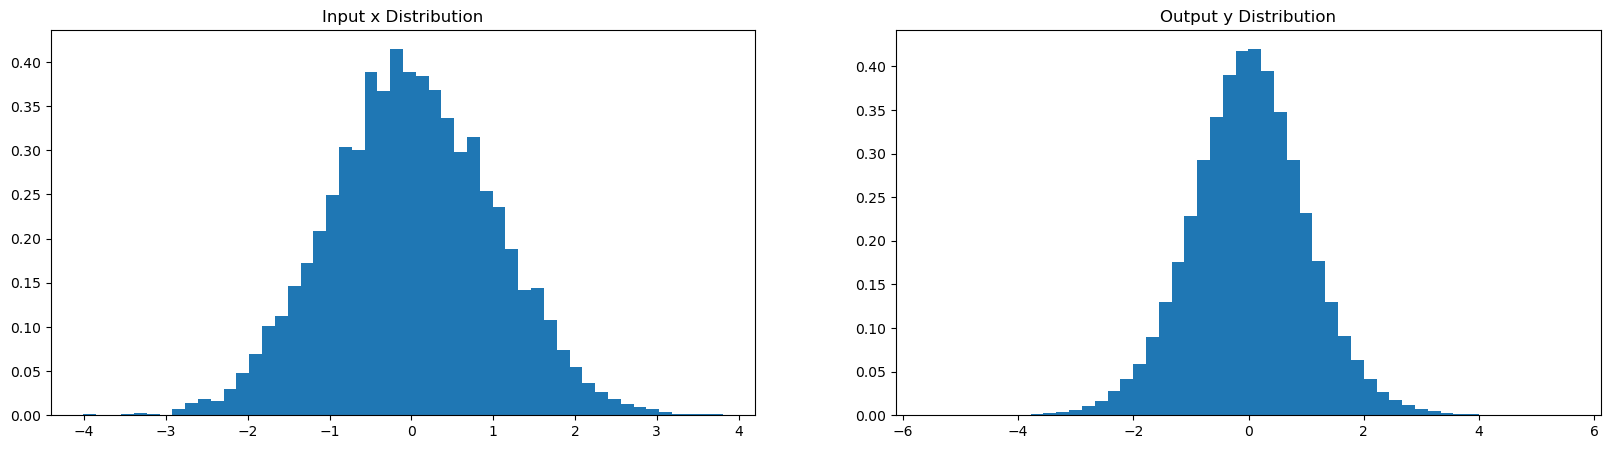

In [3]:
import torch
import matplotlib.pyplot as plt

# 初始化输入和权重
x = torch.randn(1000, 10)
w = torch.randn(10, 200) / 10**0.5   # 除以 sqrt(fan-in)

# 前向传播
y = x @ w

# 打印均值和标准差
print(x.mean(), x.std())
print(y.mean(), y.std())

# 绘制直方图，观察分布变化
plt.figure(figsize=(20, 5))

plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True)
plt.title("Input x Distribution")

plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True)
plt.title("Output y Distribution")

plt.show()

接下来讲的是BN
我们希望每一层的神经元呈现高斯分布，于是我们人为操作（当然仅仅在初始化时，在后面我们还是希望权重能自动调整）于是scale and shift
同时BN也可以看作是一种正则化(根据其他的样本稍微抖动)，effectively padding out any one of these input examples and introduce a little bit entropy,and because of these padding out ,it's actually kind of like a form fo data augmentation (augmentation the input a little bit and jittering it .) make itis harder for nn to overfit 特定的样本

basically no one like the property that the examples in the batch are coupled mathematically and in the forward pass,and it leads to all kinds of strange results,which leads to a lot of bugs and so on 
So pelple try to deprecate the the use of batchnormalization and move to other normalization techniqus that not couple the example of batch(LN,IN,GN )

batch norm推理时可以手动计算全体数据的mean和std,但是没人喜欢做第二阶段的事情，所以在训练是就动态储存mean 和std


讲了可视化参数，发现设置gain很重要，gain 是一个缩放因子（Scaling Factor），用于调整线性层（Linear Layer）权重的大小。它的作用是：
	•	抵消激活函数（特别是像 tanh 这种“压缩型激活函数”）带来的信号衰减。
	•	保持激活值在各层之间的分布稳定，避免：
	•	标准差逐层减小（信号越来越弱，导致梯度消失）。
	•	或者标准差过大导致激活值饱和（梯度为零）
    而gain=5/3似乎仅仅是经验

接下来用同样的思路，可视化梯度,探究不同gain 的作用，我们必须仔细设置这些gain ,以方便在正反向传播中获得比较好的

接下来去掉tanh的值，若保持增益为5/3，激活值的分布范围广，-40，+40，没有tanh的约束，梯度值则很多分布在-0.1-0.1,很多消失。当把增益调整为1时，表现良好

若没有tanh(激活函数)，则始终是线性变换，前向传播塌陷成一个线性层
